In [1]:
import os
import pandas as pd
import copernicusmarine
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
#importing datasets from copernicus one including sea surface temperature, bathymeter and sst.
dataset_bath = copernicusmarine.open_dataset(dataset_id ="cmems_mod_glo_phy_my_0.083deg_static")
dataset_pisces = copernicusmarine.open_dataset(dataset_id = "cmems_mod_glo_bgc_my_0.25deg_P1M-m")
dataset_sssd = copernicusmarine.open_dataset(dataset_id ="cmems_obs-mob_glo_phy-sss_my_multi_P1M")
dataset_carb = copernicusmarine.open_dataset(dataset_id ="dataset-carbon-rep-monthly")

INFO - 2024-08-09T16:07:22Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-09T16:07:22Z - Dataset part was not specified, the first one was selected: "bathy"
INFO - 2024-08-09T16:07:22Z - Service was not specified, the default one was selected: "static-arco"
INFO - 2024-08-09T16:07:30Z - Dataset version was not specified, the latest one was selected: "202406"
INFO - 2024-08-09T16:07:30Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-09T16:07:37Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-09T16:07:47Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-09T16:07:47Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-09T16:07:54Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-09T16:08:04Z - Dataset version was not specified, the latest one wa

In [3]:
#slicing for several days (for simplicity) and a also focusing on a specific area south sea
ds_bath = dataset_bath.sel(
    latitude = slice(0, 25.5),longitude = slice(98.5,122.5), depth = dataset_bath['depth'][0])

ds_pisces = dataset_pisces.sel(
    latitude = slice(0, 25.5),longitude = slice(98.5,122.5),
    time = slice('2018-02-01', '2018-02-1'))

ds_sssd = dataset_sssd.sel(
    latitude = slice(0, 25.5),longitude = slice(98.5,122.5),
    time = slice('2018-02-01', '2018-02-1'), depth = dataset_sssd['depth'][0])

ds_carb = dataset_carb.sel(
    latitude = slice(0, 25.5),longitude = slice(98.5,122.5),
    time = slice('2018-02-01', '2018-02-1'))

Use interpolate function to make the resolutions of bat, carb, sssd dataframes match to pisces.

In [4]:
#interpolate into chl dataset into temperature to make latitudes, longitudes same
interp_ds_bath = ds_bath.interp( longitude = ds_pisces["longitude"],latitude = ds_pisces["latitude"])
interp_ds_carb = ds_carb.interp( longitude = ds_pisces["longitude"],latitude = ds_pisces["latitude"])
interp_ds_sssd = ds_sssd.interp( longitude = ds_pisces["longitude"],latitude = ds_pisces["latitude"])

We convert xarray datasets to pandas dataframes. (Note that this part takes time, so after running once and saving dataframes I commented out).

In [5]:
#df_bath = ds_bath.to_dataframe().reset_index()
#df_pisces = ds_pisces.to_dataframe().reset_index()
#df_carb = ds_carb.to_dataframe().reset_index()
#df_sssd = ds_sssd.to_dataframe().reset_index()
#
#df_bath.to_csv("bath_int.csv")
#df_interp_pisces.to_csv("pisces_int.csv")
#df_interp_carb.to_csv("carb_int.csv")
#df_interp_sssd.to_csv("sssd_int.csv")

df_interp_bath = interp_ds_bath.to_dataframe().reset_index()
df_interp_carb = interp_ds_carb.to_dataframe().reset_index()
df_interp_sssd = interp_ds_sssd.to_dataframe().reset_index()

Loading the converted pandas dataframes.

In [6]:
df_bath = pd.read_csv("bath_int.csv")
df_pisces = pd.read_csv("pisces_int.csv")
df_carb = pd.read_csv("carb_int.csv")
df_sssd = pd.read_csv("sssd_int.csv")

Below are the coarse graining functions for coarse graining data just like interpolation function. They are basically same but the  `coarse_grain_bath(df, features):` lacks the time print out part as bath dataframe doesn't have that.

In [7]:
# function to coarse grain the data and make resolution same as Pisces data
def coarse_grain(df, features):
  """
    Parameters
    ----------
    df: pandas dataframe containing the data accessed from copernicus mariner
    features: name of the features in the dataframe

    Output
    ------
    a pandas dataframe with feature values for 0.25 deg x 0.25 deg resolution 

    """
  
  df["0_1"] = df["latitude"].to_numpy() - np.floor(df["latitude"])
  conditions = [df["0_1"] < 0.25,
                (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
                (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
                (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
  outputs = [0, 0.25, 0.5, 0.75]
  df['latitude'] = np.floor(df["latitude"]) + np.select(conditions, outputs)
  df = df.drop(columns=["0_1"])

  df["0_1"] = df["longitude"].to_numpy() - np.floor(df["longitude"])
  # if not redefined then conditions is based on latitude
  conditions = [df["0_1"] < 0.25,
              (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
              (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
              (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
  df['longitude'] = np.floor(df["longitude"]) + np.select(conditions, outputs)
  df = df.drop(columns=["0_1"])

  return df.groupby(["time","latitude","longitude"])[features].mean() 

In [8]:
# function to coarse grain the data and make resolution same as Pisces data
def coarse_grain_bath(df, features):
  """
    Parameters
    ----------
    df: pandas dataframe containing the data accessed from copernicus mariner
    features: name of the features in the dataframe

    Output
    ------
    a pandas dataframe with feature values for 0.25 deg x 0.25 deg resolution 

    """
  
  df["0_1"] = df["latitude"].to_numpy() - np.floor(df["latitude"])
  conditions = [df["0_1"] < 0.25,
                (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
                (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
                (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
  outputs = [0, 0.25, 0.5, 0.75]
  df['latitude'] = np.floor(df["latitude"]) + np.select(conditions, outputs)
  df = df.drop(columns=["0_1"])

  df["0_1"] = df["longitude"].to_numpy() - np.floor(df["longitude"])
  # if not redefined then conditions is based on latitude
  conditions = [df["0_1"] < 0.25,
              (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
              (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
              (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
  df['longitude'] = np.floor(df["longitude"]) + np.select(conditions, outputs)
  df = df.drop(columns=["0_1"])

  return df.groupby(["latitude","longitude"])[features].mean() 

Coarse grained dataframes below

In [9]:
df_cg_bath = coarse_grain_bath(df_bath, ['deptho'])
df_cg_carb = coarse_grain(df_carb, ['ph'])
df_cg_sssd = coarse_grain(df_sssd, ['dos'])

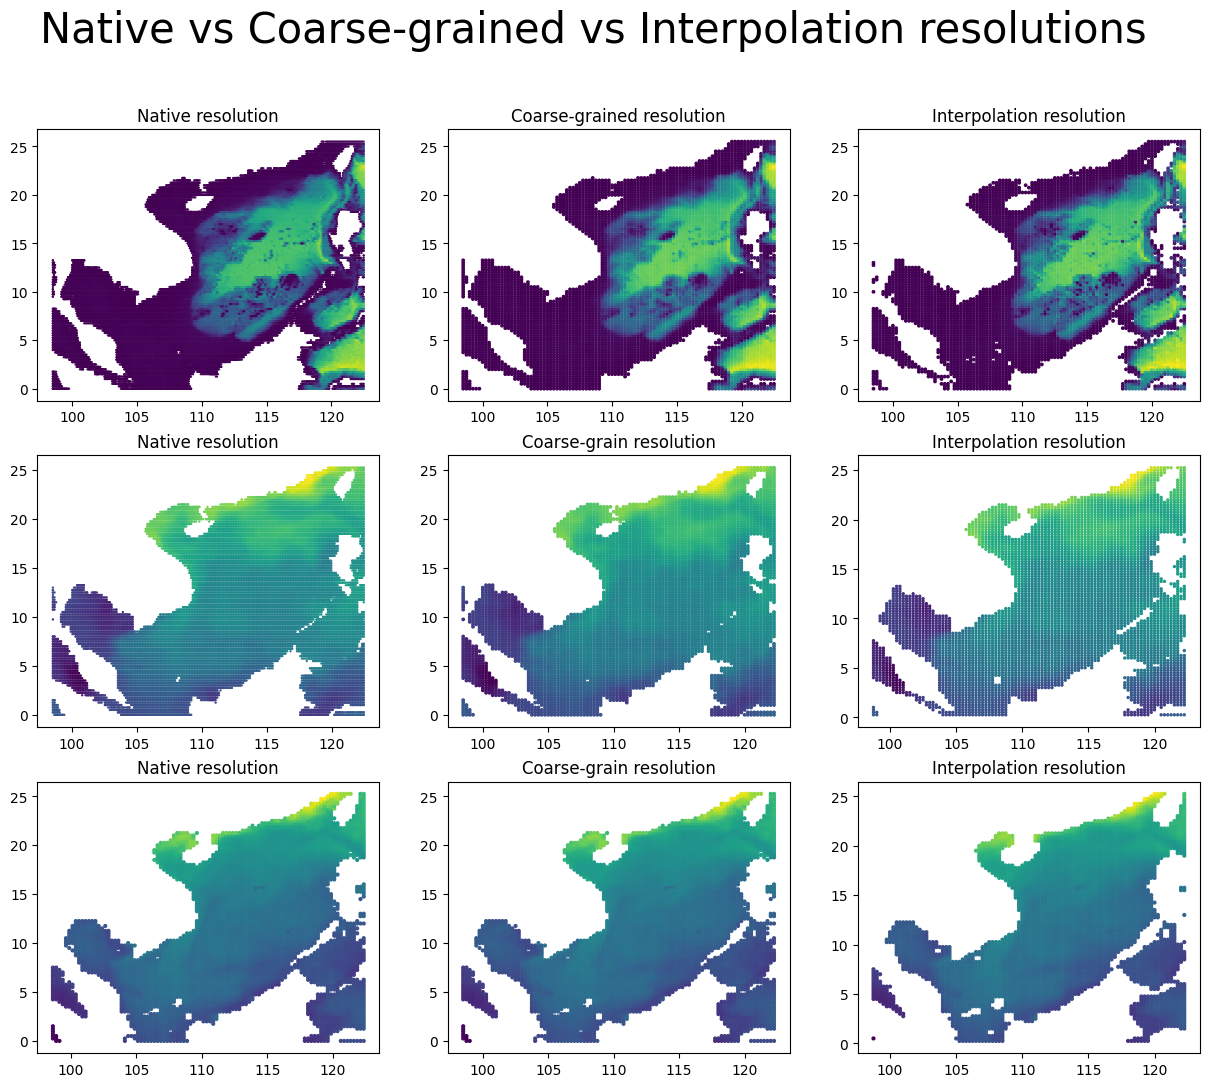

In [13]:
fig, axes = plt.subplots(ncols=3,nrows=3, figsize=(15, 12))
fig.suptitle('Native vs Coarse-grained vs Interpolation resolutions ', size=30)
axes[0,0].scatter(df_bath.reset_index()['longitude'],
           df_bath.reset_index()['latitude'] , 
           c = df_bath.reset_index()['deptho'], s=0.4)
axes[0,0].set_title("Native resolution")
axes[0,1].scatter(df_cg_bath.reset_index()['longitude'],
           df_cg_bath.reset_index()['latitude'] , 
           c = df_cg_bath.reset_index()['deptho'], s=3)
axes[0,1].set_title("Coarse-grained resolution")
axes[0,2].scatter(df_interp_bath.reset_index()['longitude'],
           df_interp_bath.reset_index()['latitude'] , 
           c = df_interp_bath.reset_index()['deptho'], s=3)
axes[0,2].set_title("Interpolation resolution")
axes[1,0].scatter(df_sssd.reset_index()['longitude'],
           df_sssd.reset_index()['latitude'] , 
           c = df_sssd.reset_index()['dos'], s=0.5)
axes[1,0].set_title("Native resolution")
axes[1,1].scatter(df_cg_sssd.reset_index()['longitude'],
           df_cg_sssd.reset_index()['latitude'] , 
           c = df_cg_sssd.reset_index()['dos'], s=3)
axes[1,1].set_title("Coarse-grain resolution")
axes[1,2].scatter(df_interp_sssd.reset_index()['longitude'],
           df_interp_sssd.reset_index()['latitude'] , 
           c = df_interp_sssd.reset_index()['dos'], s=2)
axes[1,2].set_title("Interpolation resolution")
axes[2,0].scatter(df_carb.reset_index()['longitude'],
           df_carb.reset_index()['latitude'] , 
           c = df_carb.reset_index()['ph'], s=4)
axes[2,0].set_title("Native resolution")
axes[2,1].scatter(df_cg_carb.reset_index()['longitude'],
           df_cg_carb.reset_index()['latitude'] , 
           c = df_cg_carb.reset_index()['ph'], s=4)
axes[2,1].set_title("Coarse-grain resolution")
axes[2,2].scatter(df_interp_carb.reset_index()['longitude'],
           df_interp_carb.reset_index()['latitude'] , 
           c = df_interp_carb.reset_index()['ph'], s=4)
axes[2,2].set_title("Interpolation resolution")
plt.show()